In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

In [81]:

current_dir = os.getcwd()
current_dir

'C:\\Users\\hnsaa\\Projects\\P5\\Mildew_Detection_in_Cherry_Leaves'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'C:\\Users\\hnsaa\\Projects\\P5\\Mildew_Detection_in_Cherry_Leaves'

In [82]:
my_data_dir = 'inputs/dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

In [83]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


In [84]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


In [85]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

In [86]:


# Define the directory containing your dataset
dataset_dir = "\inputs\dataset\cherry-leaves"

# Define the sets
sets = ['train', 'test', 'validation']

# Create an empty dictionary to store counts
image_counts = {}

# Iterate through each set and count the images
for set_name in sets:
    set_path = os.path.join(my_data_dir, set_name)
    labels = os.listdir(set_path)
    
    set_count = 0
    for label in labels:
        label_path = os.path.join(set_path, label)
        image_count = len(os.listdir(label_path))
        set_count += image_count

    image_counts[set_name] = set_count

# Display the counts
for set_name, count in image_counts.items():
    print(f"Number of images in {set_name}: {count}")

Number of images in train: 2944
Number of images in test: 844
Number of images in validation: 420


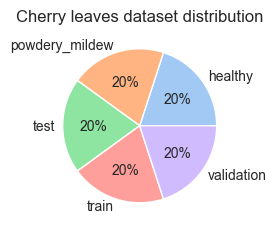

In [87]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

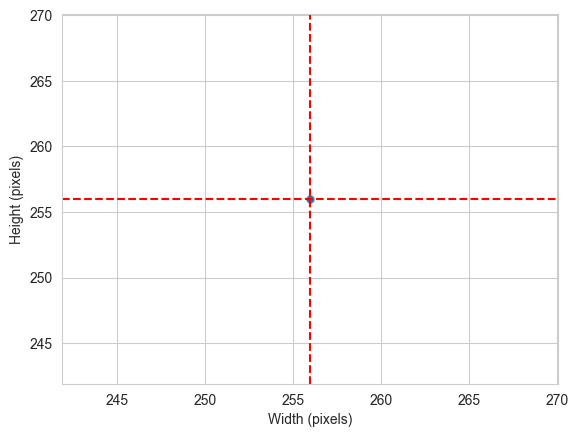

Width average: 256 
Height average: 256


In [88]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

In [89]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

In [90]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


In [91]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

In [92]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [93]:
batch_size = 16

In [94]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


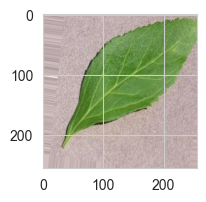

(16, 256, 256, 3)


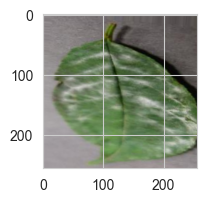

(16, 256, 256, 3)


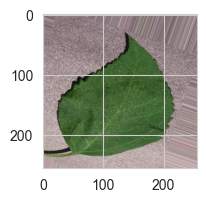

In [95]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

In [96]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


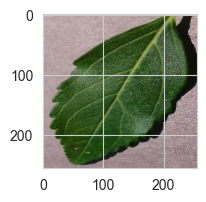

(16, 256, 256, 3)


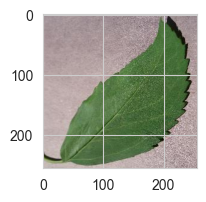

(16, 256, 256, 3)


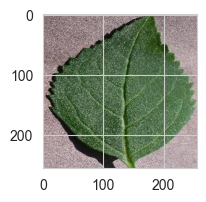

In [97]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

In [98]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


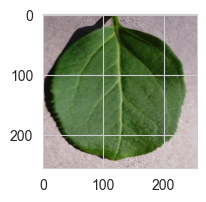

(16, 256, 256, 3)


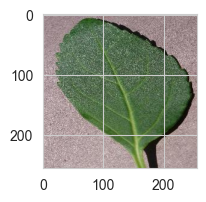

(16, 256, 256, 3)


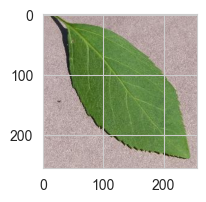

In [99]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

In [100]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

In [101]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

In [102]:
create_tf_model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 64)       

In [103]:
early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [104]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=24,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

Epoch 1/24
184/184 [==============================] - 130s 705ms/step - loss: 0.5308 - accuracy: 0.7245 - val_loss: 0.3129 - val_accuracy: 0.8929
Epoch 2/24
184/184 [==============================] - 130s 705ms/step - loss: 0.3526 - accuracy: 0.8468 - val_loss: 0.2964 - val_accuracy: 0.8690
Epoch 3/24
184/184 [==============================] - 129s 703ms/step - loss: 0.2889 - accuracy: 0.8910 - val_loss: 0.2961 - val_accuracy: 0.8690
Epoch 3: early stopping


In [105]:
model.save("outputs/v1/mildew_model.keras")

<Figure size 500x400 with 0 Axes>

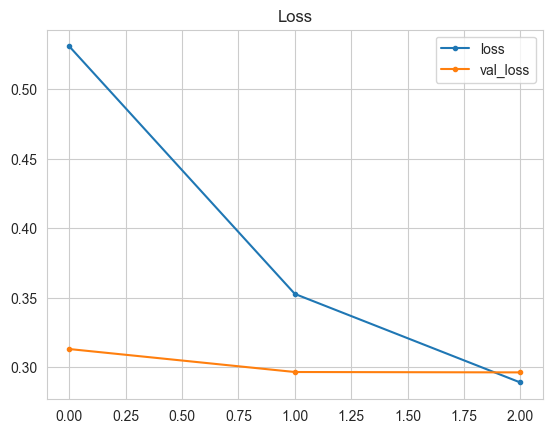

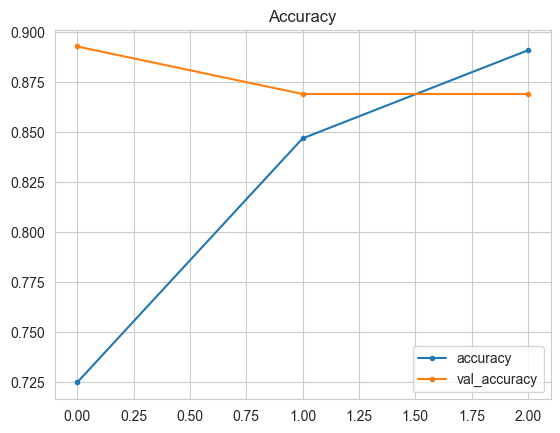

In [107]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)

plt.show()

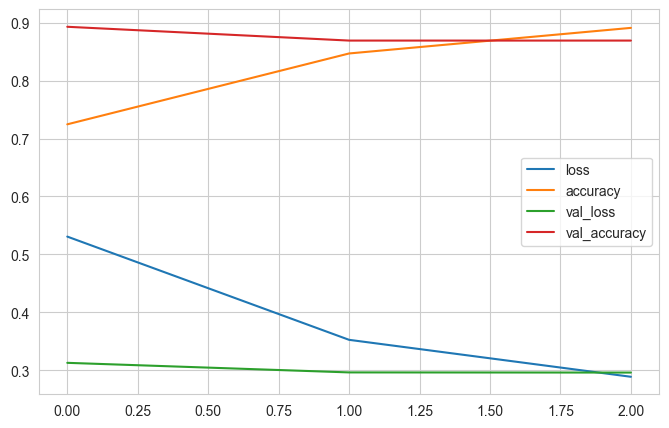

In [108]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))

plt.savefig(f'{file_path}/model_loss_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [78]:
model = load_model('outputs/v1/mildew_model.keras')

In [109]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

53/53 [==============================] - 8s 154ms/step - loss: 0.3006 - accuracy: 0.8626
Model accuracy: 86.26%
Model Loss:  0.3005821406841278


In [110]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

53/53 [==============================] - 8s 155ms/step


Area Under ROC-Curve:  0.862559241706161


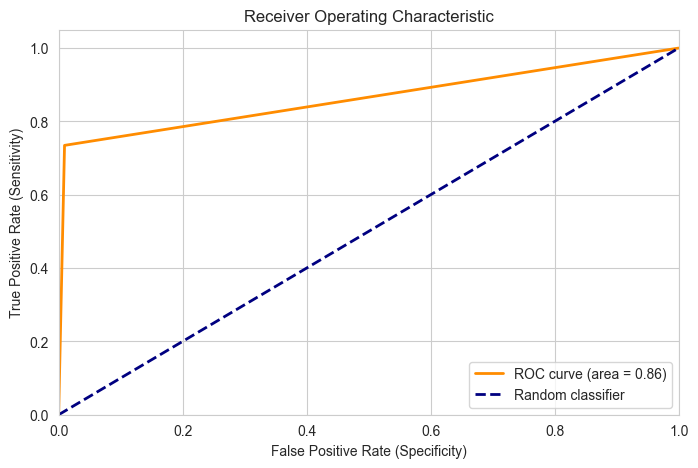

In [111]:

sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

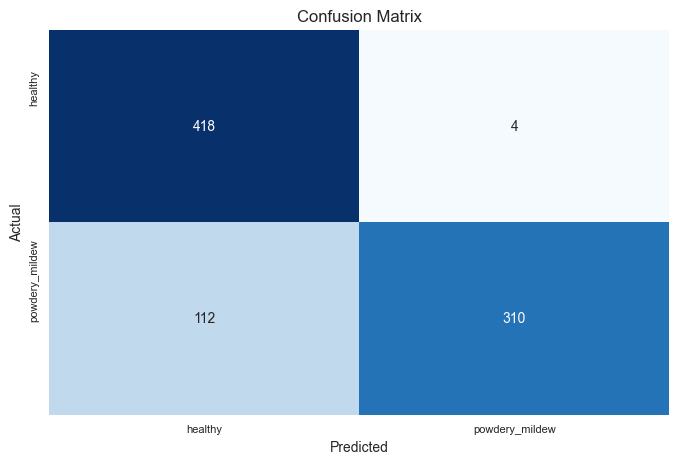

In [112]:
cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [113]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [114]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.79      0.99      0.88       422
powdery_mildew       0.99      0.73      0.84       422

      accuracy                           0.86       844
     macro avg       0.89      0.86      0.86       844
  weighted avg       0.89      0.86      0.86       844



Text(0.5, 1.0, 'Classification Report')

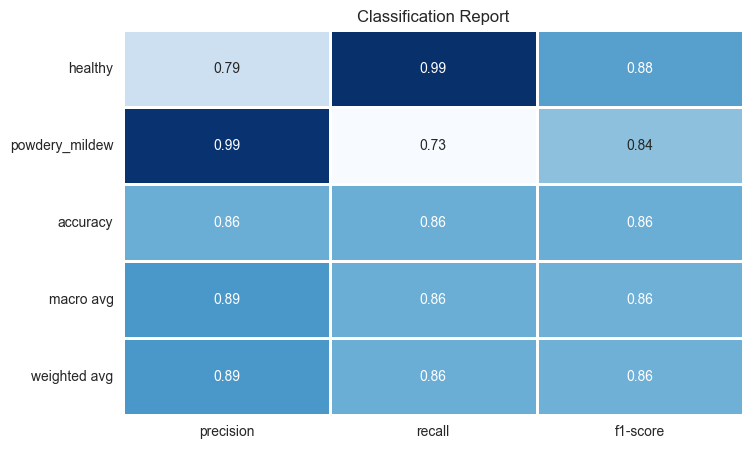

In [115]:
import matplotlib as mpl
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')

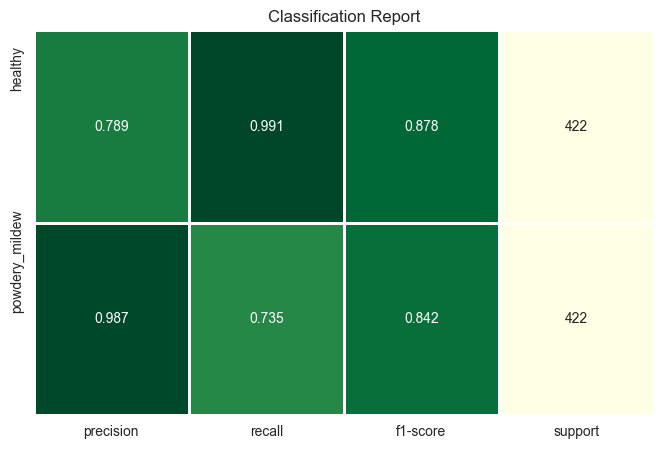

In [116]:
import matplotlib as mpl
import pathlib

def plot_classification_report(y_test, y_pred, title='Classification Report', save_fig_path=None, **kwargs):
   
    fig, ax = plt.subplots(figsize=(8,5))
        
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    #the following line ensures that dataframe are sorted from the majority classes to the minority classes
    df.sort_values(by=['support'], inplace=True) 
    
    #first, let's plot the heatmap by masking the 'support' column
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g', cbar=False,
            vmin=0.0,
            vmax=1.0,
            linewidths=.4, linecolor='white'
                    )
    
    #then, let's add the support column by normalizing the colors in this column
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 
            
    plt.title(title)
    plt.yticks(np.arange(length)+.2, classes, rotation=90)
         
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax

fig, ax = plot_classification_report(y_true, y_pred, 
                    title='Classification Report',
                    target_names=labels,
                    save_fig_path = f'{file_path}/clf_report.png',)

In [117]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

Image shape: (256, 256), Image mode: RGB


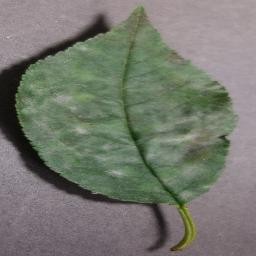

In [118]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [119]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [120]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 [==============================] - 0s 96ms/step
powdery_mildew 69.92%
